In [1]:
# Cell 1: Imports, double precision, and device
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pickle, time

torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [2]:
# Cell 2: Big, deep NN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 1)
        )
    def forward(self, x):
        return self.layers(x)
model = Net().to(device)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)
model.apply(init_weights)


Net(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): Tanh()
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [3]:
def exact_solution(x):
    # x: [N,2]
    # u(x1, x2) = x1^2 * x2^2 * (1 - x1)^2 * (1 - x2)^2
    return x[:,0]**2 * x[:,1]**2 * (1 - x[:,0])**2 * (1 - x[:,1])**2

def rhs_f(x):
    # f = Δ^2 u (biharmonic of the above)
    # For a quick implementation, use automatic differentiation to get f at sample points:
    x.requires_grad_()
    u = exact_solution(x)
    grad_u = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    lap_u = sum([
        torch.autograd.grad(grad_u[:, i], x, torch.ones_like(grad_u[:, i]), create_graph=True)[0][:, i]
        for i in range(2)
    ])
    bi_u = torch.autograd.grad(lap_u, x, grad_outputs=torch.ones_like(lap_u), create_graph=True)[0]
    biharmonic = bi_u.sum(1)
    return biharmonic  # This returns f evaluated at given x
def dirichlet_bc(x):  # Dirichlet on all boundaries
    return exact_solution(x)

In [4]:
# Cell 4: Dense points (increase for better accuracy)
N_int, N_bd = 1000, 400
def get_interior(N):
    return torch.rand(N, 2, device=device)
def get_boundary(M):
    grid = torch.linspace(0, 1, M//4, device=device)
    pts = [torch.stack([grid, torch.zeros_like(grid)], dim=1),
           torch.stack([grid, torch.ones_like(grid)],  dim=1),
           torch.stack([torch.zeros_like(grid), grid], dim=1),
           torch.stack([torch.ones_like(grid),  grid], dim=1)]
    return torch.cat(pts, dim=0)


In [5]:
# Cell 5: DRM Loss (keep penalty strong)
def drm_loss(model, x_int, x_bd, bc_weight=4000.0):
    x_int.requires_grad_()
    u = model(x_int)
    grad_u = torch.autograd.grad(u, x_int, torch.ones_like(u), create_graph=True)[0]
    lap_u = sum([
        torch.autograd.grad(grad_u[:, i], x_int, torch.ones_like(grad_u[:, i]), create_graph=True)[0][:, i]
        for i in range(2)
    ])
    bi_u = torch.autograd.grad(lap_u, x_int, grad_outputs=torch.ones_like(lap_u), create_graph=True)[0]
    biharmonic = bi_u.sum(1)
    f = rhs_f(x_int)
    energy = ((0.5 * biharmonic ** 2 - f * u.squeeze()).mean())
    u_bd = model(x_bd).squeeze()
    bc_loss = bc_weight * ((u_bd - dirichlet_bc(x_bd))**2).mean()
    return energy + bc_loss


In [6]:
# Cell 6: Training (increase epochs, schedule LR)
epochs = 12000
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.3)
losses = []
start_time = time.time()
for epoch in range(epochs):
    x_int, x_bd = get_interior(N_int), get_boundary(N_bd)
    loss = drm_loss(model, x_int, x_bd, bc_weight=4000.0)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.5)
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.6e}")

# Final LBFGS for min loss
lbfgs = torch.optim.LBFGS(model.parameters(), lr=0.5, max_iter=250)
def closure():
    x_int, x_bd = get_interior(N_int), get_boundary(N_bd)
    loss = drm_loss(model, x_int, x_bd, bc_weight=4000.0)
    lbfgs.zero_grad()
    loss.backward()
    return loss
lbfgs.step(closure)
train_time = time.time() - start_time

Epoch 0: Loss 8.522017e+01
Epoch 500: Loss 3.393006e-01
Epoch 1000: Loss 4.513803e-02
Epoch 1500: Loss 1.249494e-02
Epoch 2000: Loss 7.189547e-04
Epoch 2500: Loss 2.268832e-04
Epoch 3000: Loss 4.525378e-04
Epoch 3500: Loss 4.533746e-04
Epoch 4000: Loss 5.059885e-03
Epoch 4500: Loss 1.067426e-03
Epoch 5000: Loss 1.452052e-03
Epoch 5500: Loss -3.292699e-06
Epoch 6000: Loss -7.409005e-07
Epoch 6500: Loss -4.186812e-06
Epoch 7000: Loss 3.284154e-06
Epoch 7500: Loss -1.671307e-06
Epoch 8000: Loss -3.354730e-06
Epoch 8500: Loss 3.858087e-07
Epoch 9000: Loss 9.351419e-06
Epoch 9500: Loss -1.319034e-06
Epoch 10000: Loss -2.928488e-06
Epoch 10500: Loss -3.431915e-06
Epoch 11000: Loss -3.316392e-06
Epoch 11500: Loss -3.513027e-06


/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())


In [ ]:
# Cell 7: Save outputa
torch.save(model.state_dict(), "drm_example3_1_model.pt")

In [8]:
# Cell 8: Print arch/settings
print(f"Training time: {train_time:.2f} s")
print("NN Architecture:\n", model)
n_L = sum(torch.count_nonzero(p).item() for p in model.parameters())
print("Total nonzero parameters n_L:", n_L)
print("Adam lr: 5e-4, LBFGS steps: 250")
print("Interior pts:", N_int, "Boundary pts:", N_bd, "Boundary penalty:", 4000.0)
print(f"Final training loss: {losses[-1]:.6e}")


Training time: 2268.75 s
NN Architecture:
 Net(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): Tanh()
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)
Total nonzero parameters n_L: 30701
Adam lr: 5e-4, LBFGS steps: 250
Interior pts: 1000 Boundary pts: 400 Boundary penalty: 4000.0
Final training loss: -3.630411e-06


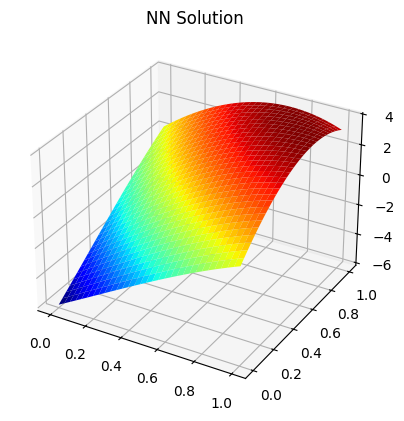

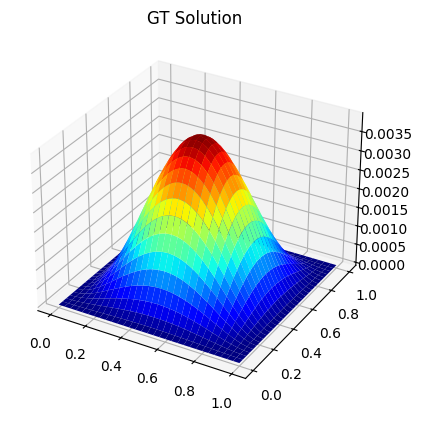

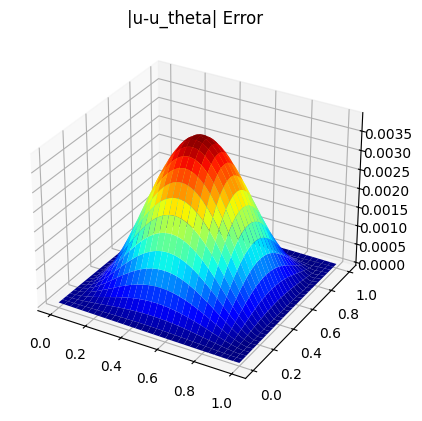

In [9]:
# Cell 9: Plot solution/error
gsize = 61
xg = np.linspace(0, 1, gsize)
mg = np.meshgrid(xg, xg)
gp = torch.tensor(np.stack([mg[0].ravel(), mg[1].ravel()], axis=-1), device=device, dtype=torch.float64)

with torch.no_grad():
    u_nn = model(gp).detach().cpu().numpy().reshape(gsize, gsize)
    u_gt = exact_solution(gp).detach().cpu().numpy().reshape(gsize, gsize)
    err = np.abs(u_nn - u_gt)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(mg[0], mg[1], u_nn, cmap='jet')
plt.title('NN Solution')
plt.savefig("NNsolution1.png")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(mg[0], mg[1], u_gt, cmap='jet')
plt.title('GT Solution')
plt.savefig("GTsol1.png")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(mg[0], mg[1], err, cmap='jet')
plt.title('|u-u_theta| Error')
plt.savefig("Error1.png")
plt.show()


In [10]:
# Cell 10: Error calculation (careful detaching!)
gp.requires_grad_()
u_gt1d = exact_solution(gp).detach().cpu().numpy()
u_nn1d = model(gp).detach().cpu().numpy()

u_gt_val = exact_solution(gp)
u_nn_val = model(gp)
u_gt_grad = torch.autograd.grad(u_gt_val, gp, torch.ones_like(u_gt_val), create_graph=True)[0]
u_nn_grad = torch.autograd.grad(u_nn_val, gp, torch.ones_like(u_nn_val), create_graph=True)[0]
u_gt_grad_np = u_gt_grad.detach().cpu().numpy()
u_nn_grad_np = u_nn_grad.detach().cpu().numpy()
H_gt = [torch.autograd.grad(u_gt_grad[:, i], gp, torch.ones_like(u_gt_grad[:, i]), create_graph=True)[0][:, i].detach().cpu().numpy() for i in range(2)]
H_nn = [torch.autograd.grad(u_nn_grad[:, i], gp, torch.ones_like(u_nn_grad[:, i]), create_graph=True)[0][:, i].detach().cpu().numpy() for i in range(2)]
def H2norm(H): return np.sqrt(sum([np.mean(h**2) for h in H]))
def H1norm(grad): return np.sqrt(np.mean(grad[:,0]**2 + grad[:,1]**2))

L2Err = np.sqrt(np.mean((u_gt1d-u_nn1d)**2))
RelL2Err = L2Err / np.sqrt(np.mean(u_gt1d**2))
energyErr = L2Err + H1norm(u_gt_grad_np-u_nn_grad_np)
relEnergyErr = energyErr / (np.sqrt(np.mean(u_gt1d**2)) + H1norm(u_gt_grad_np))
H2Err = H2norm([H_gt[0]-H_nn[0], H_gt[1]-H_nn[1]])
relH2Err = H2Err / H2norm(H_gt)

print(f"L2 Error: {L2Err:.3e}")
print(f"Relative L2 Error: {RelL2Err:.3e}")
print(f"Energy Error (L2 + H1): {energyErr:.3e}")
print(f"Relative Energy Error (H1Relative): {relEnergyErr:.3e}")
print(f"H2 Error: {H2Err:.3e}")
print(f"Relative H2 Error: {relH2Err:.3e}")


L2 Error: 1.556e-03
Relative L2 Error: 9.969e-01
Energy Error (L2 + H1): 9.183e-03
Relative Energy Error (H1Relative): 9.971e-01
H2 Error: 5.166e-02
Relative H2 Error: 1.000e+00


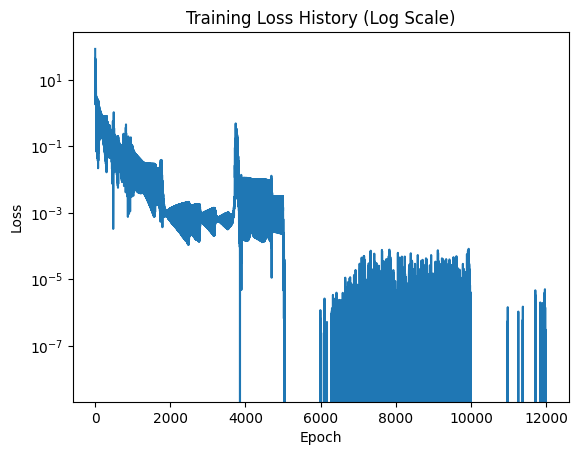

In [11]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')  # <- THIS is the key change!
plt.title("Training Loss History (Log Scale)")
plt.savefig("LossHistory1_log.png")
plt.show()